## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`).

In [1]:
!pip install tqdm

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
df = pd.read_csv(data)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
df.card = (df.card == 'yes').astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [8]:
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- **`share`**

In [9]:
df.nunique()

card              2
reports          13
age             418
income          431
share          1162
expenditure     981
owner             2
selfemp           2
dependents        7
months          193
majorcards        2
active           35
dtype: int64

In [10]:
df.dtypes

card             int32
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [11]:
numerical = ['reports',
             'age',
             'income',
             'share',
             'expenditure',
             'dependents',
             'months',
             'active']
categorical = ['owner',
               'selfemp',
               'majorcards']

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [13]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%11s, %.3f' % (c, auc))

    reports, 0.717
        age, 0.524
     income, 0.591
      share, 0.989
expenditure, 0.991
 dependents, 0.533
     months, 0.529
     active, 0.604


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [14]:
columns = ["reports",
           "age",
           "income",
           "share",
           "expenditure",
           "dependents",
           "months",
           "majorcards",
           "active",
           "owner",
           "selfemp"]

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- **0.995**

In [17]:
roc_auc_score(y_val, y_pred).round(3)

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* **0.3**
* 0.6
* 0.8

In [18]:
from tqdm.auto import tqdm

In [19]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [20]:
score_columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=score_columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

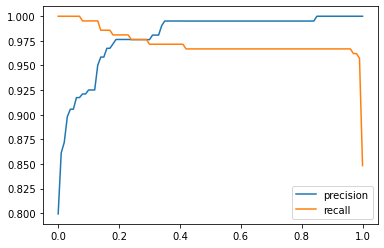

In [21]:
plt.plot(df_scores.threshold, df_scores['p'], label='precision')
plt.plot(df_scores.threshold, df_scores['r'], label='recall')
plt.legend()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- **0.4**
- 0.6
- 0.7

In [22]:
df_scores['f1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

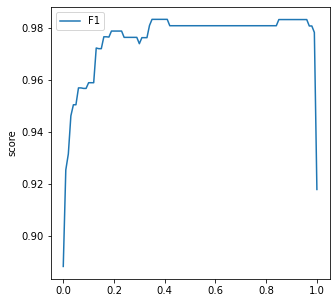

In [23]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.ylabel('score')
plt.legend()

In [24]:
df_scores['threshold'][(df_scores['f1'] == df_scores['f1'].max())]

35    0.35
36    0.36
37    0.37
38    0.38
39    0.39
40    0.40
41    0.41
Name: threshold, dtype: float64

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- **0.003**
- 0.014
- 0.09
- 0.24

In [30]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [31]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [32]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- **1**
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [25]:
from sklearn.model_selection import KFold

In [35]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one

## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.